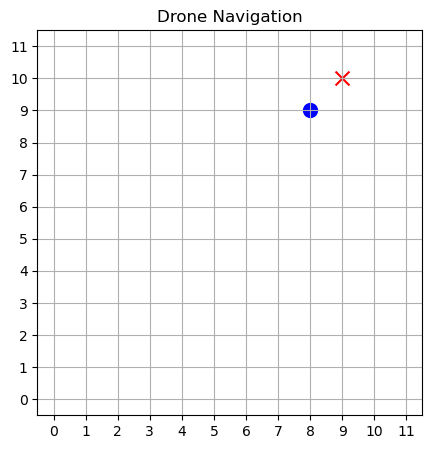

In [1]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env


class DroneNavigation(gym.Env):
    metadata = {'render.modes': ['human', 'rgb_array', 'none']}
    
    def __init__(self, area_size=(10, 10), start_position=None, target_position=None, max_steps=100, render_mode='human'):
        super(DroneNavigation, self).__init__()
        self.area_size = area_size
        self.max_steps = max_steps
        self.render_mode = render_mode
        self.action_space = spaces.Discrete(4) 
        self.observation_space = spaces.Box(low=0, high=max(area_size), shape=(4,), dtype=np.int32)
        
    
        self.initial_start_position = start_position  
        self.initial_target_position = target_position 
        
    
        self.reset()  
        if self.render_mode == 'human':
            plt.ion()
            self.fig, self.ax = plt.subplots(figsize=(5, 5))
    
    def reset(self, **kwargs):
        
        if self.initial_start_position is not None:
            self.drone_position = list(self.initial_start_position)
        else:
            self.drone_position = [np.random.randint(0, self.area_size[0]), np.random.randint(0, self.area_size[1])]
        
        if self.initial_target_position is not None:
            self.target_position = list(self.initial_target_position)
        else:
            self.target_position = [np.random.randint(0, self.area_size[0]), np.random.randint(0, self.area_size[1])]
        
        self.current_step = 0
        observation = np.array(self.drone_position + self.target_position, dtype=np.float32)
        return observation, {}
    
    def render(self, mode='human'):
        if mode == 'human' and hasattr(self, 'ax'): 
            self.ax.clear()
            self.ax.imshow(np.zeros(self.area_size), cmap='Greys', origin='lower')
            self.ax.scatter(*self.target_position[::-1], color='red', marker='x', s=100)
            self.ax.scatter(*self.drone_position[::-1], color='blue', s=100)
            self.ax.grid(True)
            self.ax.set_xticks(range(self.area_size[0]))
            self.ax.set_yticks(range(self.area_size[1]))
            self.ax.set_title("Drone Navigation")
            display(self.fig)
            clear_output(wait=True)
            plt.pause(0.1)
        else:
            print("No visual rendering setup available.")
            
            
     
    def step(self, action):
        if action == 0 and self.drone_position[1] < self.area_size[1] - 1:
            self.drone_position[1] += 1
        elif action == 1 and self.drone_position[1] > 0:
            self.drone_position[1] -= 1
        elif action == 2 and self.drone_position[0] > 0:
            self.drone_position[0] -= 1
        elif action == 3 and self.drone_position[0] < self.area_size[0] - 1:
            self.drone_position[0] += 1

        self.current_step += 1
        done = self.current_step >= self.max_steps
        reward = -1
        if self.drone_position == self.target_position:
            reward = 100
            done = True

        info = {}
        terminated = self.current_step >= self.max_steps or self.drone_position == self.target_position
        truncated = self.current_step >= self.max_steps
        return np.array(self.drone_position + self.target_position, dtype=np.float32), reward, terminated, truncated, info


    def close(self):
        pass       
    

def create_env():
    user_choice = input("Would you like to manually set the parameters? (y/n): ").lower()
    if user_choice == 'y':
        area_size = (int(input("Enter the area size X: ")), int(input("Enter the area size Y: ")))
        max_steps = int(input("Enter the maximum number of steps allowed: "))
        start_x = int(input("Enter the drone's starting X position: "))
        start_y = int(input("Enter the drone's starting Y position: "))
        target_x = int(input("Enter the target X position: "))
        target_y = int(input("Enter the target Y position: "))
        start_position = (start_x, start_y)
        target_position = (target_x, target_y)
    else:
        area_size = (10, 10) 
        max_steps = 100 
        start_position = None
        target_position = None
    
    return DroneNavigation(area_size=area_size, start_position=start_position, target_position=target_position, max_steps=max_steps, render_mode='human')


env = make_vec_env(create_env, n_envs=1)
model = PPO("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=50000)

obs = env.reset()
for _ in range(100):
    action = model.predict(obs, deterministic=True)[0]
    obs, rewards, dones, info = env.step(action)
    env.render()
